Neuromorphic engineering I

## Lab 6: Integrator Circuits

Group number: 4.5

Team member 1: Jan Hohenheim

Team member 2: Maxim Gärtner

Date:

-------------------------------------------------------------------------------------------------------------------

**Objectives of this lab:** 
In this lab we will begin to explore the time domain using the follower-integrator and the follower-differentiator circuit.

Both circuits simply contain a transconductance amplifier and a capacitor to implement a low-pass or high-pass filter.

We will use the follower-integrator (FOI) and follower-differentiator circuit on the CoACH chip. The capacitance for both capacitors is $1pF$.

The objectives of the lab are:
1. Understand the behavior of the first-order low-pass follower-integrator and high-pass follower-differentiator circuit in the time and frequency domain in small signal operation.

_First-order_ means that the transfer function amplitude decreases as 1/frequency.

_Low-pass_ ( _High-pass_ ) means that the circuit passes low (high) frequencies and blocks high (low) frequencies.

_Follower-integrator_ ( _Follower-differentiator_ ) means that the output follows the input at low (high) frequencies, and integrates (differentiates) at higher (lower) frequencies.

2. Understand the large signal behavior and other limitations of using a transconductance amplifier to model a linear resistor.

# 1 Reading

See Chapters 8 and 9 of the Carver Mead book ("Analog VLSI and Neural
Systems"), paying particular attention to the time and frequency domain
treatments of the RC circuit, pages 240-241 and 246-249 in Chapter 8,
and the follower-integrator circuit, pages 252-256 in
Chapter 9. Slides are also available introducing linear systems analysis.


# 2 Prelab

1. How are capacitors constructed in CMOS chip technology?  There are  several different possible implementations.  How are they   constructed in neurons? What is the capacitance per square micron of a $\text{SiO}_2$ capacitor with 
	oxide thickness of 10nm?  What is the capacitance per square micron area of a lipid-bilayer 
	capacitance with thickness of 5nm? (You will need to look up the dielectric constants for 
	$\text{SiO}_2$ and lipid bilayers; remember to provide your sources in your writeup. One standard source for lipid bilayers is Ohki, Shinpei. "Dielectric constant and refractive index of lipid bilayers." Journal of Theoretical Biology 19.1 (1968): 97-115 \footnote{\url{https://www.sciencedirect.com/science/article/pii/0022519368900088}}.)

> - CMOS capacitors are mostly either implemented as metal-oxide-metal layers in a pattern that resembles intersecting forks or by using the transistor itself as a capacitor, with the gate and the drain + source acting as plates and the thin layer oxide as insulator. The latter's capacitance is dependent on the gate voltage.  
> 
> - A neuron uses it's phospholipid-bylayer as an insulator, where $K^+$, $\text{Ca}^{2+}$, $\text{Na}^+$ and $\text{Cl}^-$ ions and charged proteins are the charge carriers. This behaves like a capacitor, since to change the membrane potential, the membrane capacitance needs to be charged.
>
> - Capacitance: $C = K \varepsilon_0 \frac{A}{d}$ where $\varepsilon_0 \approx 8.86 \text{e}{-12}\frac{F}{m}$  
> - For the class chip, $K \approx 3.9$ per the data we received in lab 2. So the capacitance is $3.9 \times 8.86\text{e}{-12}\frac{F}{m} \frac{1m^{-2}}{10\text{e}{-9}\text{m}} = 3.46\text{e}{-3}\frac{F}{m^2} = 3.46\frac{fF}{\mu m^2}$  
> - For a phospholipid bilayer of thickness 5nm, $K \approx 5$ (Source: _J. C. Weaver and K. H. Schoenbach, "Biodielectrics," in IEEE Transactions on Dielectrics and Electrical Insulation, vol. 10, no. 5, pp. 715-716, Oct. 2003, doi: 10.1109/TDEI.2003.1237322._). So the capacitance is $5 \times 8.86\text{e}{-12}\frac{F}{m} \frac{1m^{-2}}{5\text{e}{-9}\text{m}} = 8.86\text{e}{-3}\frac{F}{m^2} = 8.86\frac{fF}{\mu m^2}$


2. Derive the transfer function $H(s)=\frac{V_{out}}{V_{in}}$ for the follower-integrator, using the _s_-plane notation, expressed in terms of complex frequency $s$ and the time constant $\tau$.


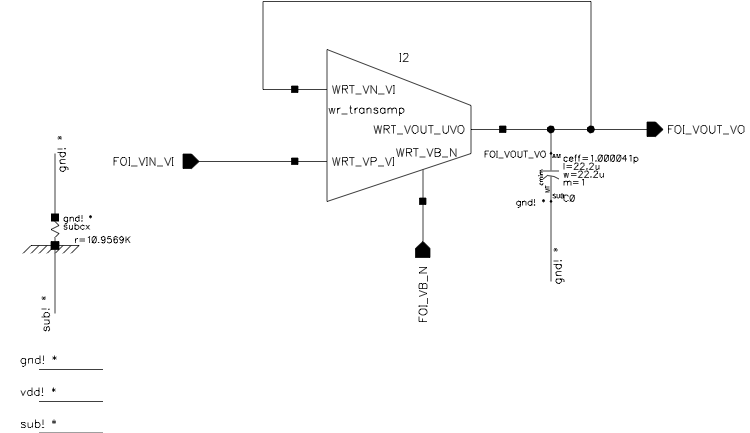

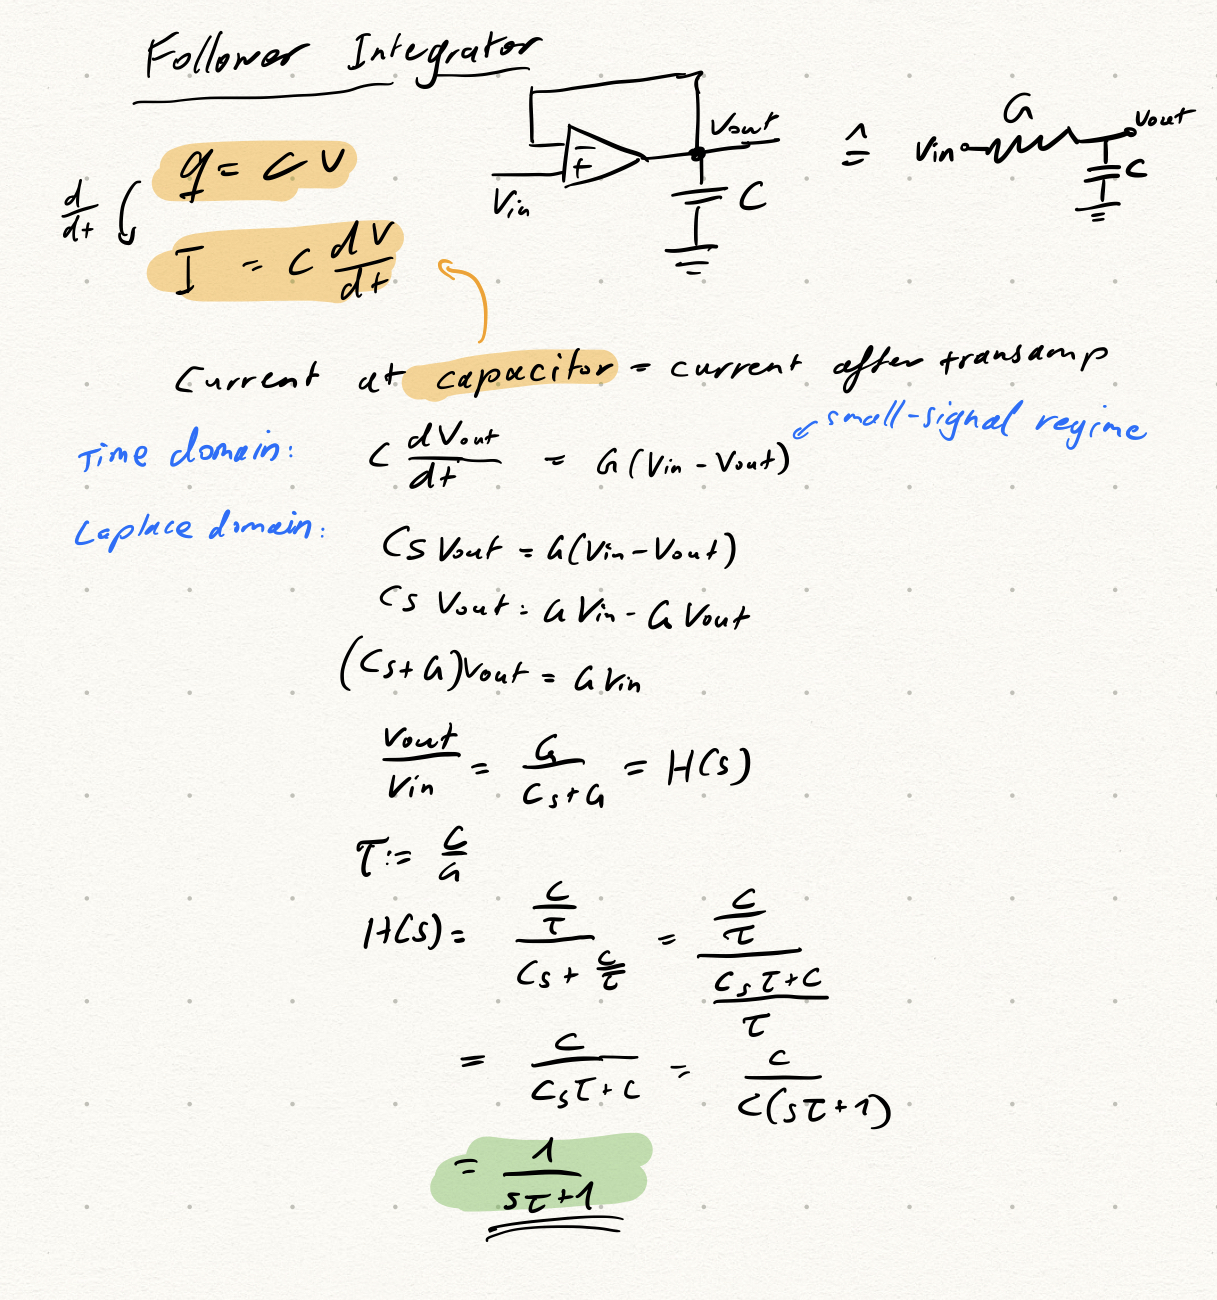

3. Compute the transfer function $H(s)=\frac{V_{out}}{V_{in}}$ for the follower-differentiator, using the _s_-plane notation, expressed in terms of complex frequency $s$ and the time constant $\tau$.

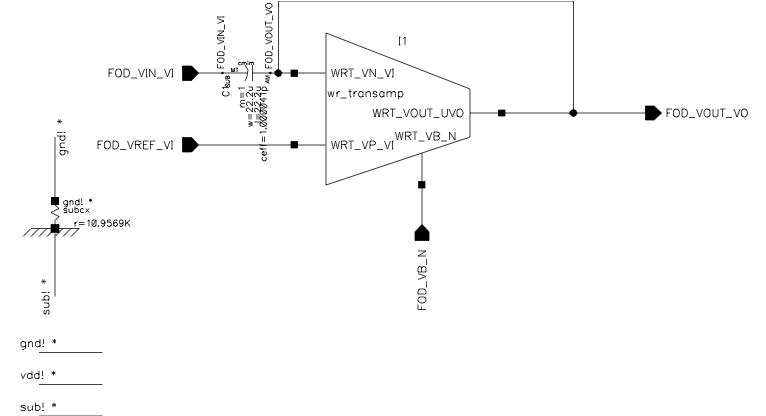

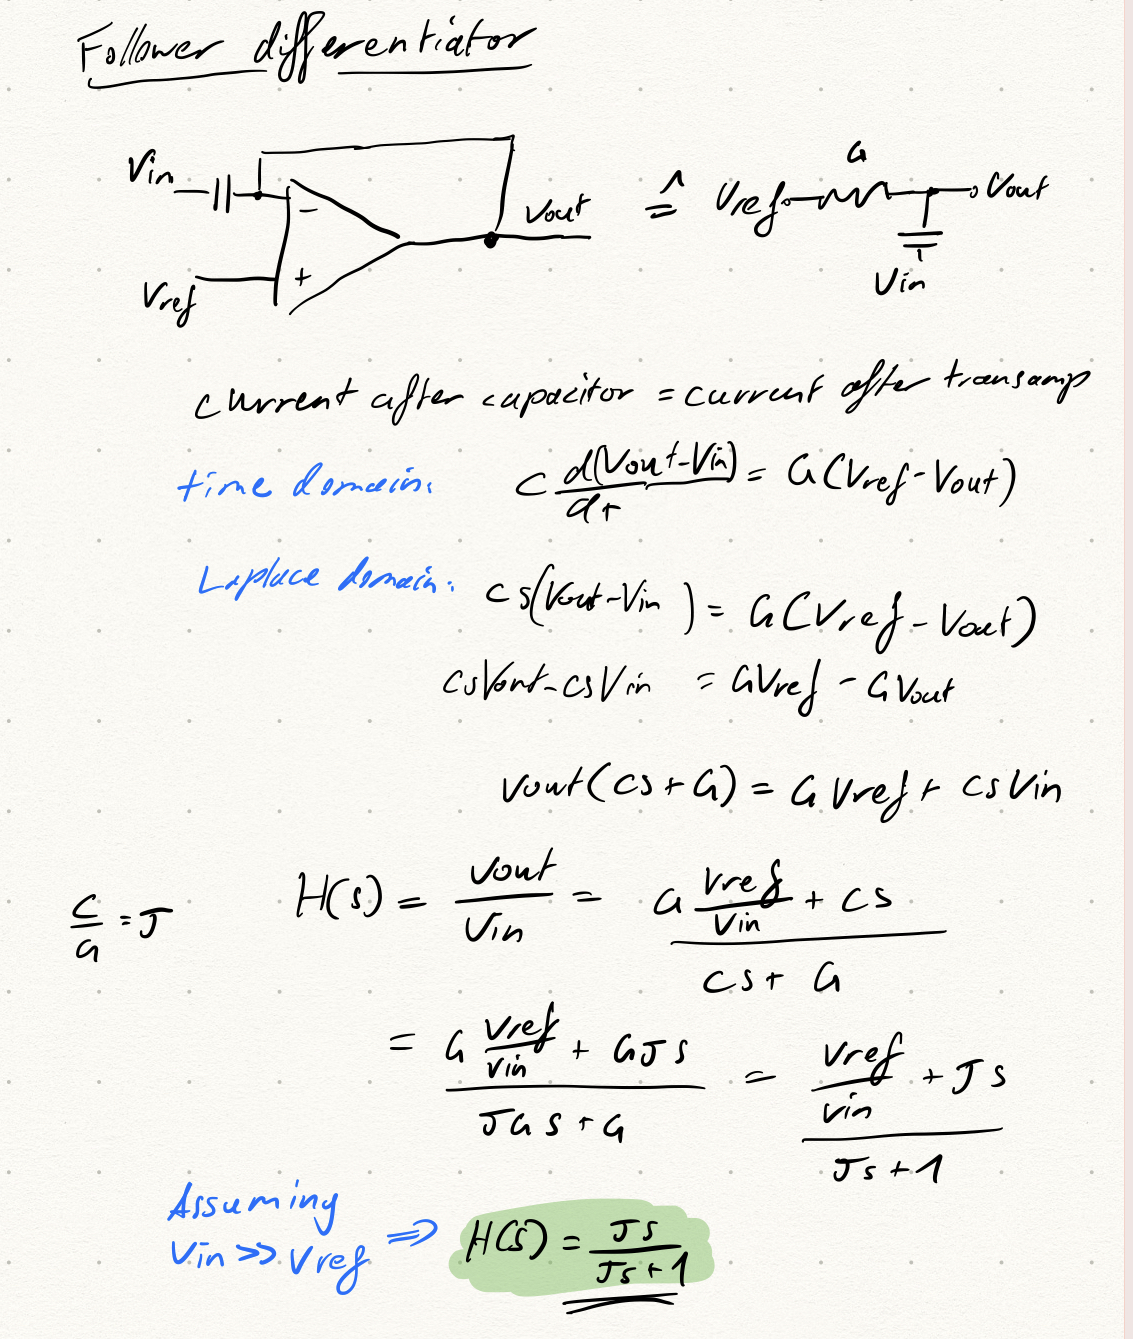

4. Compute the magnitude $|H(s)|$ for the follower integrator for input angular frequency $\omega$. At what frequency $f$ in Hz does the power drop to half its low frequency value (amplitude drops to $1/\sqrt{2}$)? 

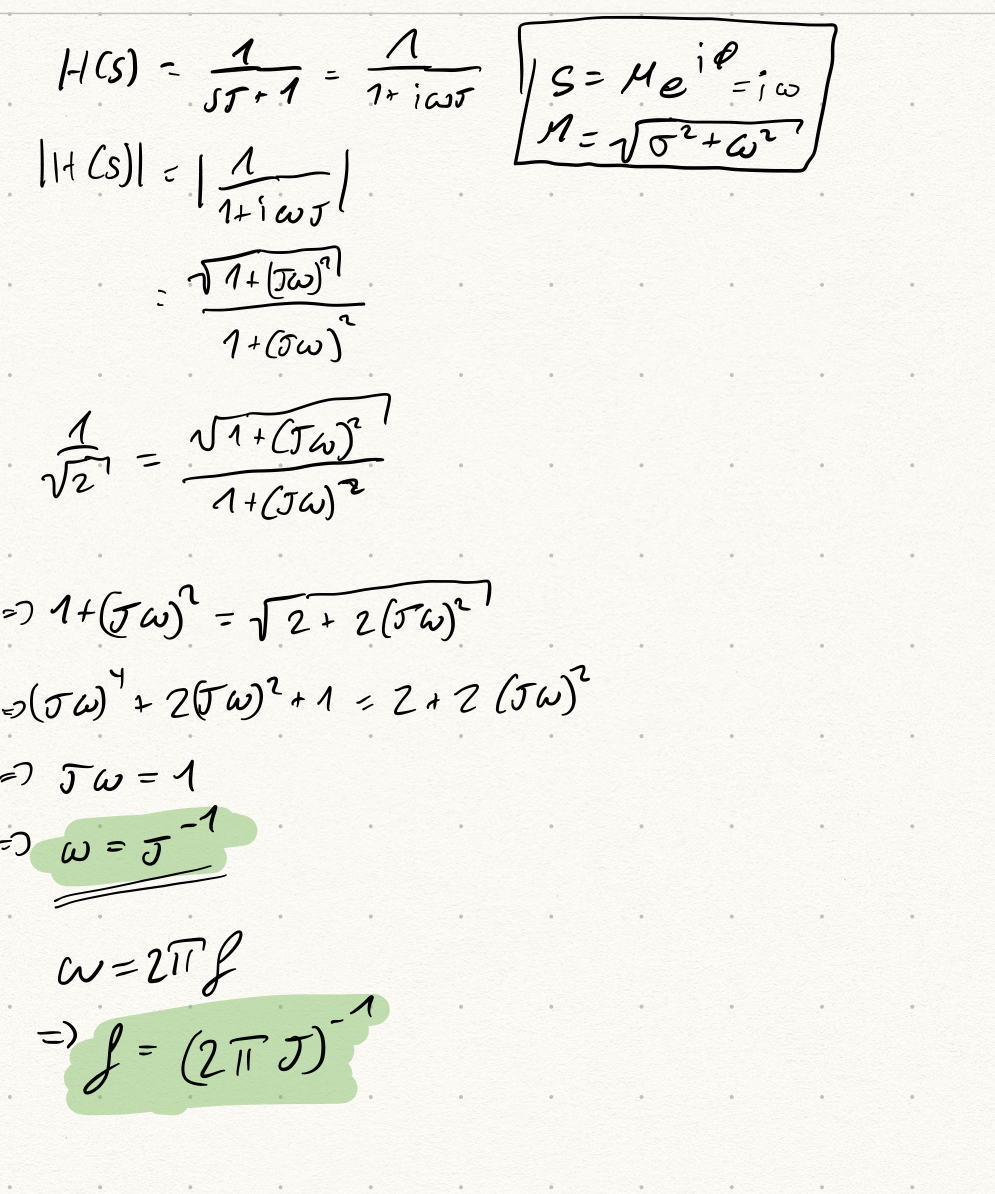

5. Compare the simple _RC_ integrator, constructed from a resistor and a capacitor, and the follower-integrator to show how the transfer function falls short in describing the follower integrator. In particular, how does the follower integrator respond to large signal inputs? This question is related to the next one, which is

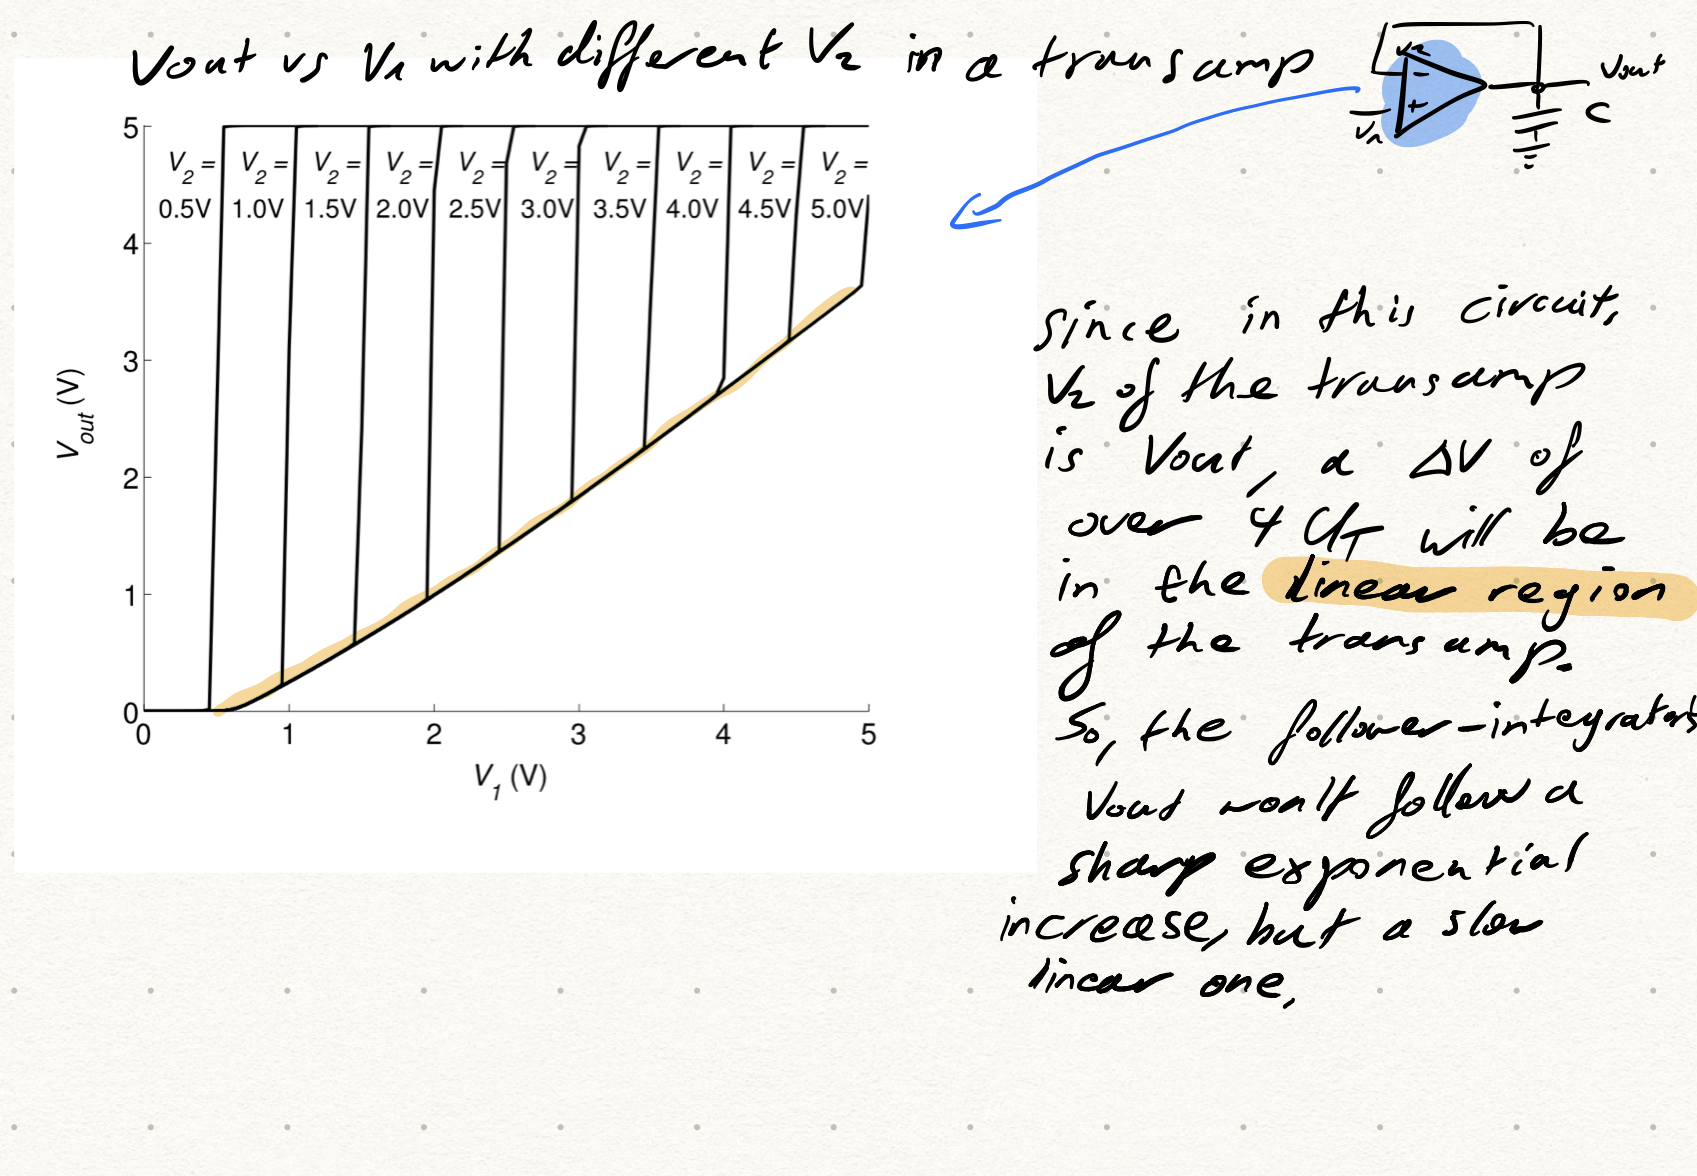

6. What does ''small-signal'' mean?  In other words, what voltage range will this regime correspond to?  For the follower-integrator circuit is it the _amplitude_ of the input or the output or the _difference_ between the two that matters? Why?


> The difference: $|V_{in} - V_{out}| < 4U_T$ (assuming $\kappa \approx 1$).  
> The reason is stated above.

# 3 Setup

## 3.1 Connect the device

In [1]:
# import the necessary library to communicate with the hardware
import pyplane
import time
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# create a Plane object and open the communication
if 'p' not in locals():
    p = pyplane.Plane()
    try:
        p.open('/dev/ttyACM0')
    except RuntimeError as e:
        del p
        print(e)

In [3]:
p.get_firmware_version()

(1, 8, 4)

In [4]:
# Send a reset signal to the board, check if the LED blinks
p.reset(pyplane.ResetType.Soft)
time.sleep(0.5) 
# NOTE: You must send this request events every time you do a reset operetion, otherwise the recieved data is noisy.
# Because the class chip need to do handshake to get the communication correct.
p.request_events(1)

In [5]:
# Try to read something, make sure the chip responses
p.read_current(pyplane.AdcChannel.GO0_N)

1.7724609335800778e-07

## 3.1 Chip configuration

Both circuits we use today uses the same configuration, so we just need to do it once at the beginning.

In [6]:
p.send_coach_events([pyplane.Coach.generate_aerc_event(
    pyplane.Coach.CurrentOutputSelect.SelectLine0,
    pyplane.Coach.VoltageOutputSelect.SelectLine1,
    pyplane.Coach.VoltageInputSelect.SelectLine2,
    pyplane.Coach.SynapseSelect.NoneSelected,0)])

## 3.2 Bias Generator (BiasGen or BG)

In a simplified form, the output of a branch of the BiasGen will be the gate voltage $V_b$ for the bias current $I_b$, and if the current mirror has a ratio of $w$ and the bias transistor operates in subthreshold-saturation:
\begin{equation}
I_b = w\frac{BG_{fine}}{256}I_{BG_{master}}
\end{equation}
Where $I_{BG_{master}}$ is the `BiasGenMasterCurrent` $\in \left\{ 60~\rm{pA}, 460~\rm{pA}, 3.8~\rm{nA}, 30~\rm{nA}, 240~\rm{nA} \right\}$, $BG_{fine}$ is the integer fine value $\in [0, 256)$

To set a bias, use the function similar to the following:

```
p.send_coach_event(pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.BIAS_NAME_STARTS_WITH_THREE_LETTER_CIRCUIT_NAME, \
    pyplane.Coach.BiasType.MATCH_LAST_CHAR_OF_BIAS_NAME, \
    pyplane.Coach.BiasGenMasterCurrent.MASTER_CURRENT, FINE_VALUE))
```

# 4 Follower-integrator (FOI)

## 4.1 Schematic and pin map

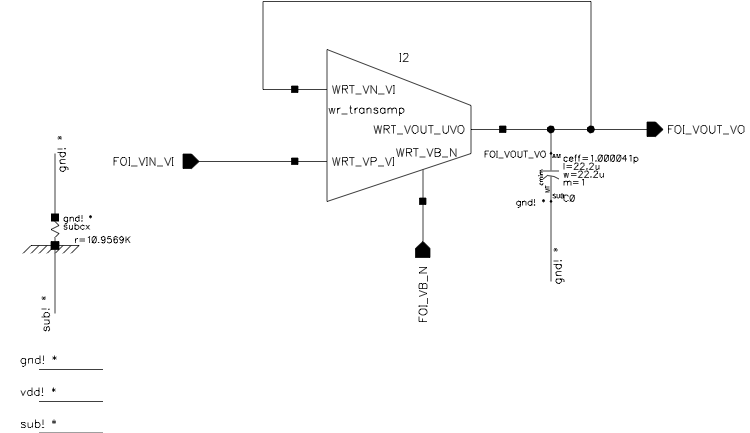

**$V_{in}$ = FOI_VIN_VI = AIN9**

**$V_{out}$ = FOI_VOUT_VO = ADC[10]**

**$C$ = ceff = 1 pF**

* The W/L of the output transistor of the BiasGen is 4u/12u, and the bias transistor $M_b$ of wide-range-transamp is 1u/1u, which give a ratio of **$w$ = 3**. This means if you set the bias current to (3.8 nA, 225), you will get $I_b = 3.8\times\frac{67}{256}\times3 = 3$ nA instead of 1 nA.

## 4.2 Time-domain response of small signal

### 4.2.1 Set parameters

* The maximum sampling frequency of the ADC is 100 kHz (10 $\mu$s), and the maximum number of samples is 250. Let's say if we want to cover the time period of $10\tau$ with these 250 samples, what should the value of $\tau$ be (assume $\kappa=1$)?

In order to cover a period of $10\tau$ with n samples, each sample should have the duration

$\Delta t = \dfrac{10\tau}{n}$.

As 

$f = \dfrac{1}{\Delta t}$,

it can be inferred that

$\tau = \dfrac{n}{10f}$.

Setting $f = 100 \cdot 10^3 \text{Hz}$ and $n=250$ yields

$\tau = 250 \cdot 10^{-6}\text{s} = 250 \mu\text{s} $.

* To get this $\tau$, what is the value of $I_b$?

From the prelab, it is known that

$\tau = \dfrac{2U_T}{I_b\kappa}C$.

With $U_T \approx 25\text{mV}$, $\kappa = 1$, $\tau = 250\mu\text{s}$ and $C = 1\text{pF}$ it follows that

$I_b = \dfrac{2U_T}{\tau}C \approx 200\text{pA}$.

* What `MasterCurrent` and `fine` value should we use for $I_b$? Please set below.

In [7]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(
    pyplane.Coach.BiasAddress.FOI_VB_N,
    pyplane.Coach.BiasType.N,
    pyplane.Coach.BiasGenMasterCurrent.I460pA, 37)])

For a given value of $I_b$, it is sensible to choose the next largest value for $I_{BG_{master}}$. In the case of $I_b = 200\text{pA}$, this is

$I_{BG_{master}} = 460\text{pA}$.

With $I_b = 200\text{pA}$ and $w=3$, it can be calculated that

$BG_{fine} = \dfrac{256I_b}{wI_{BG_{master}}} \approx 37.10 $,

which has to be rounded down to 

$BG_{fine} \approx 37$

as $BG_{fine}$ must be an integer. This yields the bias current

$I_b = w\dfrac{BG_{fine}}{256}I_{BG_{master}} \approx 199.5\text{pA}$.

* What should the input before the step $\left(V_{in}(t < 0)\right)$ be (Hint: common-mode voltage of the (wide-range) transamp)? What is the corresponding $V_{out}$ in steady state $\left(V_{out}(t=0^-)\right)$? 

In [8]:
Vi_pre = 0.9

In stead state, the value of $V_{in}$ should be high enough that the transamp is capable of operating, e.g. 

$V_{in}(t<0) = 0.9\text{V}$.

The value of the output voltage will then also be

$V_{out}(t<0) =0.9\text{V}$.

* What does "small signal" mean? What should the magnitude of the step input ($\Delta V_{in}$) be so that it can be treated as "small"?

In [9]:
dVi = 0.09

In the prelab, it was determined that small signals can be assumed if the change between the input and output voltage is limited to approximately$^{(1)}$ $\left|V_{out}-V_{in}\right|=\left|\Delta V_{in}\right|<4U_T $ over one time interval $\tau$
 
$\dfrac{d\left|\Delta V_{in}\right|}{d\tau} < 4U_T \approx 100\text{mV}$.

As a step response is considered, the change $|\Delta V_{in}|$ occurs instantaneously, and the above condition can simply be written as 

$|\Delta V_{in}| < 4U_T \approx 100\text{mV}$.

Thus, it is sensible to set e.g. $|\Delta V_{in}| \approx 90\text{mV}$.

$^{(1)}$ For $\kappa \approx 1$.

### 4.2.2 Data aquisition

* Verify the steady state

In [10]:
p.set_voltage(pyplane.DacChannel.AIN9, Vi_pre)
time.sleep(0.5) # wait for the circuit to reach steady state
Vo_pre = p.read_voltage(pyplane.AdcChannel.AOUT10)
print(Vo_pre)

0.905566394329071


* There is a small offset of the DAC of around -10 mV, but the ADC is correct, so we want to correct `Vi_pre` accordingly.

Ignore offset as setting resolution of the DAC isn't good enough to compensate the offset.

In [11]:
Vi_off = Vo_pre - Vi_pre
Vi_pre_corr = Vi_pre - Vi_off
print(Vi_pre_corr)

0.894433605670929


* Acquire the step response.

In [12]:
p.set_bit_depth(pyplane.BitDepth(10))

In [13]:
Vout_ex_4_2_2 = np.zeros(511)
for _ in range(10):
    p.set_voltage(pyplane.DacChannel.AIN9, Vi_pre_corr)
    time.sleep(0.5) # wait for the circuit to reach steady state
    Vout_ex_4_2_2 = Vout_ex_4_2_2 + p.acquire_transient_response(pyplane.DacChannel.AIN9, pyplane.AdcChannel.AOUT10, 0.00002, Vi_pre_corr + dVi)
    time.sleep(0.5) # wait to receive the measured data from the microcontroller

Vout_ex_4_2_2 /= 10
print(Vout_ex_4_2_2)

[0.90113526 0.90468018 0.9072583  0.91120605 0.91338134 0.91902099
 0.92425781 0.9273999  0.93142822 0.93392578 0.93908203 0.94383546
 0.94657471 0.94987794 0.95132813 0.9564038  0.96067383 0.96244628
 0.96558838 0.96615235 0.97098632 0.97372559 0.97557862 0.97662598
 0.97735108 0.98186279 0.98339356 0.98548828 0.98508545 0.98581054
 0.99032227 0.99040284 0.9916919  0.99080566 0.99217529 0.99491454
 0.99555908 0.99676757 0.99451172 0.99700929 0.999104   0.99918457
 0.9995874  0.99845948 0.99999024 1.00192383 1.00176268 1.00240722
 1.00039307 1.00264893 1.00409914 1.00353516 1.00409914 1.00176269
 1.00482423 1.00522707 1.00482423 1.00490479 1.0032129  1.00571047
 1.00611327 1.00571045 1.00587157 1.0029712  1.00691894 1.00651611
 1.00611329 1.00450195 1.00466307 1.00748291 1.00635497 1.00635499
 1.00490478 1.00571043 1.00909427 1.00643554 1.00675781 1.00530764
 1.00635498 1.00877198 1.00716064 1.00708008 1.00498534 1.00691894
 1.0079663  1.0070801  1.00748289 1.00530761 1.00732179 1.0078

* plot $V_{out}$

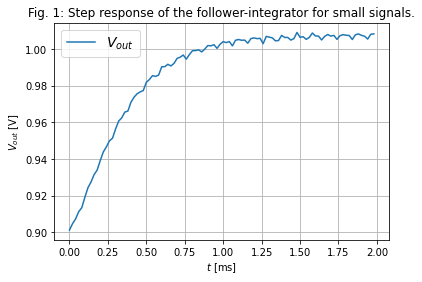

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Vout_ex_4_2_2 = np.loadtxt('data/data_ex_4_2_2.csv', delimiter=',')
t=np.arange(0,len(Vout_ex_4_2_2))*0.00002
plt.plot(t[:100]*1000, Vout_ex_4_2_2[:100])
plt.xlabel('$t$ [ms]')
plt.ylabel('$V_{out}$ [V]')
plt.legend(['$V_{out}$'],prop={'size': 14})
plt.title('Fig. 1: Step response of the follower-integrator for small signals.')
plt.grid()
plt.show()

* save data

In [15]:
# if the data looks nice, save it!
data_ex_4_2_2= [Vout_ex_4_2_2]
# save to csv file
np.savetxt('data/data_ex_4_2_2.csv', data_ex_4_2_2, delimiter=',')

### 4.2.3 Compute the time constant $\tau$ by reading from the decay in the curve

* Assume the input step happens at exactly $t=0$, what is the expression of $V_{out}$ at $t = \tau$?

In the prelab, the transfer function of the follower-integrator was derived to be

$H(s) = \dfrac{V_{out}}{V_{in}} = \dfrac{1}{\tau s + 1}$.

It is known that the unit step can be described in the s-plane as

$U(s) = \dfrac{\Delta V_{in}}{s}$.

The unit step response can thus be evaluated to

$V(s) = H(s)U(s) = \dfrac{\Delta V_{in}}{s(\tau s +1)}$. Transformed back into the time domain, the output voltage can now be described by

$V_{out}(t) = \Delta V_{in}\left(1-e^{-\dfrac{t}{\tau}}\right) + V_{out}(t=0)$.

Thus

$V_{out}(t=\tau) = \Delta V_{in}(1-\frac{1}{e}) + V_{out}(t=0)$

* Compute $\tau$ by "reading" this point from the curve:

In [18]:
import scipy.interpolate as interpolate

f = interpolate.interp1d(Vout_ex_4_2_2,t) # Interpolate t vs. Vout 
v_1tau = dVi*(1-np.exp(-1))+Vout_ex_4_2_2[0]
tau1 = f(v_1tau) # Get tau = t(Vout=1-e^(-1))
print(tau1)

0.0003075985834036632


* Compute the actual $\kappa$ by comparing the measured $\tau$ and the estimated value in 4.2.1 with $\kappa=1$.

In [19]:
Ibe = 200
Ibm = 199.5
taue = 250
taum = tau1*10**6
kappa1 = (taue*Ibe)/(taum*Ibm)
print(kappa1)

0.8147845274278835


### 4.2.5 Analysis

* Is the "small signal" assumption validated by the measurement? Why or why not?

> Yes, because the output rises quickly exponentially.

* Is the assumption "input step happens at exactly $t=0$" validated by the measurement? How can you get the actual time it takes place?

> $V_{out}$ at $t=0$ is already 0.9 V. We can extrapolate the input step time by following the slope of $V_{out}$ to the left until $V_{out} = 0$.

## 4.3 Time-domain response of large signal

### 4.3.1 Set parameters

* What does "large signal" mean? What should the magnitude of the step input ($\Delta V_{in}$) be so that it can be treated as "large"?

In [19]:
dVi = 0.3

Large signal behavior can be assumed when $\left|V_{in}-V_{out}\right|>4U_T$, which translates to the step input

$\left|\Delta V_{in}\right| > 4U_T \approx 100\text{mV}$.

Thus, it is reasonable to assumed that e.g. $\Delta V_{in} = 300\text{mV}$.

* What should the input before the step $\left(V_{in}(t < 0)\right)$ be (Hint: common-mode voltage of the (wide-range) transamp)? What is the corresponding $V_{out}$ in steady state $\left(V_{out}(t=0^-)\right)$? 

In [18]:
Vi_pre = 0.9

In stead state, the value of $V_{in}$ should be high enough that the transamp is capable of operating, e.g. 

$V_{in}(t<0) = 0.9\text{V}$.

The value of the output voltage will then also be

$V_{out}(t<0) =0.9\text{V}$.

* Let's still set ADC sampling rate as 100 kHz (10 $\mu$s), and the maximum number of samples as 250. If we want the linear part to be about 40% of the whole sampled period, what should the slew rate be (Hint: in [V/s])?

Assuming that $f=100\cdot 10^3\text{Hz}$ and that $n=250$, the total sample period will be

$t_{tot} = \dfrac{n}{f} = 2.5\cdot 10^{-3}\text{s} = 2.5\text{ms}$.

Therefore, the linear part should be approximately

$t_{lin} = 0.4t_{tot} = 1\text{ms}$

long. 


The slew rate limits the circuit as long as the $\tanh$ in $I_{out}$ is more or less saturated. In terms of $V_{in} - V_{out}$, this is given when the extrapolated linear section of $I_{out}$ intercepts $I_b$. Since the linear section of $I_{out}$ is given by

$I_{out} = g_m\left(V_{in}-V_{out}\right) = I_b\dfrac{\kappa}{2 U_T}\left(V_{in}-V_{out}\right) $.

Thus (assuming that $\kappa =1$) 

$V_{in}-V_{out} = \dfrac{2 U_T}{\kappa} = 50\text{mV}$

when the circuit is no longer limited by the slew rate. Since $\Delta V_{in} = 300\text{mV}$, the corresponding change in output voltag thus has to reach

$\Delta V_{out} = 250\text{mV}$.

The corresponding slew rate would thus be

$sr = \dfrac{\Delta V_{out} }{t_{lin}}= \dfrac{250\text{mV}}{1\text{ms}} = 250\dfrac{V}{s}$.

* To get this slew rate, what is the value of $I_b$ (Hint: $C$ = 1 pF)?

For large signals, the output current of the transamp is saturated and the transamp can thus be treated as a constant current source with $I_{out} = I_b$. This current now charges the capacitor linearily. With $t_{lin} = 1\text{ms}$, $\Delta V_{out,lin} = 250\text{mV}$ and $C = 1  \text{pF}$, it can be determined what value $I_b$ must have in order to achieve the slew rate determined in the previous exercise

$I_{out} = I_b = \dfrac{C}{t_{lin}}\Delta V_{out,lin} = C \cdot sr= 250\text{pA}$.

* What `MasterCurrent` and `fine` value should we use for $I_b$? Please set below.

In [53]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(
    pyplane.Coach.BiasAddress.FOI_VB_N,
    pyplane.Coach.BiasType.N,
    pyplane.Coach.BiasGenMasterCurrent.I460pA, 46)])

For a given value of $I_b$, it is sensible to choose the next largest value for $I_{BG_{master}}$. In the case of $I_b = 250\text{pA}$, this is

$I_{BG_{master}} = 460\text{pA}$.

With $I_b = 250\text{pA}$ and $w=3$, it can be calculated that

$BG_{fine} = \dfrac{256I_b}{wI_{BG_{master}}} \approx 46.38 $,

which has to be rounded down to 

$BG_{fine} \approx 46$

as $BG_{fine}$ must be an integer. This yields the bias current

$I_b = w\dfrac{BG_{fine}}{256}I_{BG_{master}} \approx 248.0\text{pA}$.

### 4.3.2 Data aquisition

* Verify the steady state

In [54]:
p.set_voltage(pyplane.DacChannel.AIN9, Vi_pre)
time.sleep(0.5) # wait for the circuit to reach steady state
Vo_pre = p.read_voltage(pyplane.AdcChannel.AOUT10)
print(Vo_pre)

0.909594714641571


* There is a small offset of the DAC of around -10 mV, but the ADC is correct, so we want to correct the DAC accordingly.

In [55]:
Vi_off = Vo_pre - Vi_pre
Vi_pre_corr = Vi_pre - Vi_off
print(Vi_pre_corr)

0.890405285358429


* Acquire the step response

In [56]:
p.set_bit_depth(pyplane.BitDepth(10))

In [60]:
Vout_ex_4_3_2 = np.zeros(252)
for _ in range(10):
    p.set_voltage(pyplane.DacChannel.AIN9, Vi_pre_corr)
    time.sleep(0.5) # wait for the circuit to reach steady state
    timestep = 0.00002
    Vout_ex_4_3_2 = Vout_ex_4_3_2 + p.acquire_transient_response(pyplane.DacChannel.AIN9, pyplane.AdcChannel.AOUT10, timestep, Vi_pre_corr + dVi)
    time.sleep(0.5) # wait to receive the measured data from the microcontroller

Vout_ex_4_3_2 /= 10
print(Vout_ex_4_3_2)

[0.90032959 0.90250489 0.90717773 0.91072266 0.9204712  0.92828614
 0.93150879 0.93650391 0.93924317 0.9489917  0.95793457 0.96139893
 0.96639404 0.97026123 0.9792041  0.98790527 0.99104736 0.99733154
 0.99950685 1.00949708 1.01779541 1.02085693 1.02722168 1.0297998
 1.03850099 1.0478467  1.05090821 1.05606445 1.0600122  1.06806885
 1.07660888 1.08063722 1.08635744 1.08861328 1.09650879 1.10512937
 1.11028564 1.11455568 1.11681154 1.12365967 1.13163574 1.13646971
 1.13961182 1.1415454  1.1463794  1.15250244 1.15798095 1.15918945
 1.16055908 1.16273438 1.16942137 1.17353029 1.1734497  1.17449706
 1.17457763 1.17916992 1.18352051 1.18327879 1.18335938 1.18231202
 1.18625977 1.19036865 1.18899904 1.1883545  1.18650147 1.19044923
 1.19391357 1.19197998 1.19270507 1.19004639 1.19286619 1.19608889
 1.1947998  1.1950415  1.19181885 1.19391357 1.19689454 1.19665283
 1.19633058 1.1933496  1.19471924 1.19834472 1.19882812 1.19681396
 1.19512209 1.19479982 1.19850587 1.20035889 1.19745851 1.19633

* plot $V_{out}$

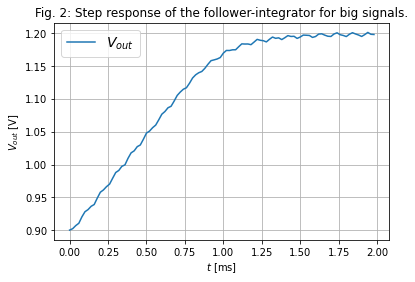

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Vout_ex_4_3_2= np.loadtxt('data/data_ex_4_3_2.csv', delimiter=',')
t=np.arange(0,len(Vout_ex_4_3_2))*0.00002
plt.plot(t[:100]*1000, Vout_ex_4_3_2[:100])
plt.xlabel('$t$ [ms]')
plt.ylabel('$V_{out}$ [V]')
plt.legend(['$V_{out}$'],prop={'size': 14})
plt.title('Fig. 2: Step response of the follower-integrator for big signals.')
plt.grid()
plt.show()

* save data

In [61]:
# if the data looks nice, save it!
data_ex_4_3_2= [Vout_ex_4_3_2]
# save to csv file
np.savetxt('data/data_ex_4_3_2.csv', data_ex_4_3_2, delimiter=',')

### 4.3.3 Data processing

* Compute the slew rate by fitting the linear part of the curve

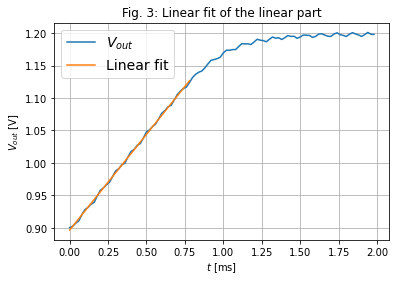

The slew rate is:  294.89685751595636


In [6]:
Vout_ex_4_3_2= np.loadtxt('data/data_ex_4_3_2.csv', delimiter=',')
t=np.arange(0,len(Vout_ex_4_3_2))*0.00002
linear_part = Vout_ex_4_3_2[:40]
a0, a1 = np.polyfit(t[:40], Vout_ex_4_3_2[:40], 1)
plt.plot(t[:100]*1000, Vout_ex_4_3_2[:100], label='$V_{out}$')
plt.plot(t[:40]*1000, t[:40]*a0 + a1, label='Linear fit')
plt.xlabel('$t$ [ms]')
plt.ylabel('$V_{out}$ [V]')
plt.legend(prop={'size': 14})
plt.title('Fig. 3: Linear fit of the linear part')
plt.grid()
plt.show()
slew_rate = a0
print("The slew rate is: ", slew_rate)

* Calculate the bias current $I_b$ from the slew rate and compare it with the set value. Comment on possible reason of any discrepancy.

In [7]:
capacitance = 1e-12
I_b = capacitance*slew_rate
print("The calculated bias current from the measurement is: ", I_b * 1e12, "pA")
set_I_b = 250e-12
print("The bias current calculated when setting BGfine is: ", set_I_b * 1e12, "pA")
print("So, the difference is ", (I_b - set_I_b)*1e12, "pA")


The calculated bias current from the measurement is:  294.89685751595636 pA
The bias current calculated when setting BGfine is:  250.00000000000003 pA
So, the difference is  44.89685751595635 pA


* Compute the time constant $\tau$ and the $\kappa$ by fitting the exponential part of the curve. Do they make sense?

In [29]:
import scipy.interpolate as interpolate

f = interpolate.interp1d(Vout_ex_4_3_2,t) # Interpolate t vs. Vout 
v_1tau = dVi*(1-np.exp(-1))+Vout_ex_4_3_2[0]
tau1 = f(v_1tau) # Get tau = t(Vout=1-e^(-1))
print(tau1)

0.0006634259335780621


In [30]:
Ibe = 200
Ibm = 199.5
taue = 250
taum = tau1*10**6
kappa1 = (taue*Ibe)/(taum*Ibm)
print(kappa1)

0.3777762576514505


> The measured $\tau$ and $\kappa$ are too low because they are in the part of the graph that does not follow the exponential formula. So, this calculation doesn't make much sense.

### 4.3.4 Analysis

* Is the assumption "input step happens at exactly $t=0$" validated by the measurement? How can you get the actual time it takes place?

> $V_{out}$ at $t=0$ is already 0.9 V. We can extrapolate the input step time by following the slope of $V_{out}$ to the left until $V_{out} = 0$.

* Could you give a marginal value of $\Delta V_{in}$ between "small" and large signal"? (Hint: assume for the transamp, $I_{out} \propto (V_1-V_2)$ if $g_m|V_1-V_2| < I_b$)

> The margin is at $g_m\varDelta V_{in} = I_b = 294pA$.  
> Using $C = 1pF$ and $g_m = \frac{C}{\tau}$ with $\tau = 0.3ms$, we get  
> $\varDelta V_{in} = \frac{I_b \tau}{C} = 0.0882$, which is also $4U_T \kappa$

## 4.4 Frequency-domain response

### 4.4.1 Methodology

In the prelab we have computed the magnitude of the transfer function $H(s)$. In this exercise we are going to measure this curve.

* What will the output signal $V_{out}$ look like if the input $V_{in}$ is a sine wave in steady state (after several cycles)?

The output signal will be phase shifted and scaled depending on the frequency of the input sine wave.

* In order to make the measurement more accurate, we set $I_b$ to minimum (about 0.7 pA):

In [63]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(
    pyplane.Coach.BiasAddress.FOI_VB_N,
    pyplane.Coach.BiasType.N,
    pyplane.Coach.BiasGenMasterCurrent.I60pA,100)])

* With this $I_b$, what is the cutoff frequency approximately?

It is known from the prelab that at the cutoff frequency,

$\omega = 2\pi f = \dfrac{1}{\tau }$.

As 

$\tau = \dfrac{C}{g_m} = \dfrac{\kappa}{2I_bU_T}C$

the cut of frequency can thus be calculated (using $\kappa = 0.9616$ as determined in exercise 4.2.3)

$f_c =I_b \dfrac{\kappa}{4\pi U_TC} \approx 2.152\text{Hz}$.

### 4.4.2 Observe the input and output waveforms

* set a sine wave

In [36]:
wf = np.sin(np.arange(0, 8*3.14, 0.1))

* set the input voltage (offset of the input sine wave is 0.9, amplitude of the input sine wave is 0.1)

In [105]:
p.set_voltage_waveform(0.9 + 0.1 * wf)

* Plot $V_{in}$ and $V_{out}$ in the same figure

In [111]:
interval = 0.01
Vout_ex_4_4_2 = p.acquire_waveform(pyplane.DacChannel.AIN9, pyplane.AdcChannel.AOUT10, interval)

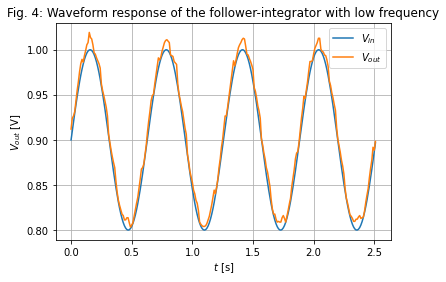

In [39]:
x = np.array(range(len(wf))) * interval
plt.plot(x, 0.9 + 0.1 * wf, label="$V_{in}$")
Vout_ex_4_4_2 = np.loadtxt('data/data_ex_4_4_2.csv', delimiter=',')
plt.plot(x, Vout_ex_4_4_2, label='$V_{out}$')
plt.xlabel('$t$ [s]')
plt.ylabel('$V_{out}$ [V]')
plt.legend()
plt.grid()
plt.title('Fig. 4: Waveform response of the follower-integrator with low frequency')
plt.show()

* Save data

In [112]:
# if the data looks nice, save it!
data_ex_4_4_2= [Vout_ex_4_4_2]
# save to csv file
np.savetxt('data/data_ex_4_4_2.csv', data_ex_4_4_2, delimiter=',')

* Is the circuit "following" or "integrating"?

> It's following the input current

* Can you change the frequency to make it operate in the other regime and plot $V_{in}$ and $V_{out}$ in the same figure

In [120]:
interval = 0.0001
Vout_ex_4_4_3 = p.acquire_waveform(pyplane.DacChannel.AIN9, pyplane.AdcChannel.AOUT10, interval)

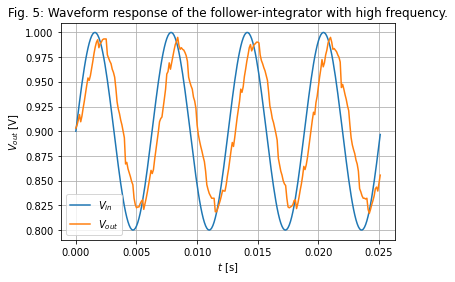

In [41]:
x = np.array(range(len(wf))) * interval
plt.plot(x, 0.9 + 0.1 * wf, label="$V_{in}$")
Vout_ex_4_4_3 = np.loadtxt('data/data_ex_4_4_3.csv', delimiter=',')
plt.plot(x, Vout_ex_4_4_3, label='$V_{out}$')
plt.xlabel('$t$ [s]')
plt.ylabel('$V_{out}$ [V]')
plt.legend()
plt.grid()
plt.title('Fig. 5: Waveform response of the follower-integrator with high frequency.')
plt.show()

* Save data

In [121]:
# if the data looks nice, save it!
data_ex_4_4_3= [Vout_ex_4_4_3]
# save to csv file
np.savetxt('data/data_ex_4_4_3.csv', data_ex_4_4_3, delimiter=',')

* How to compute the transfer function at one frequency and extract the cutoff frequenc? Can you briefly give the basic method? (Optional)